In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
from collections import deque
from copy import deepcopy
from random import sample
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Orstein-Uhlenbeck process
class OUNoise():
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.3):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu
    
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state
    
    def sample_tensor(self, dim):
        x = torch.ones(dim) * self.mu
        dx = self.theta * (self.mu - x) + self.sigma * torch.randn(dim)
        return x + dx

In [10]:
net = Net(2, 12, 12, 1, True)
n = OUNoise(action_dimension=2)
n.sample_tensor(net.fc1.weight.shape)

tensor([[-0.2655,  0.3591],
        [ 0.0763, -0.0593],
        [-0.1275,  0.7004],
        [ 0.1077, -0.4094],
        [ 0.0843,  0.2262],
        [ 0.2701,  0.3770],
        [ 0.4450, -0.1927],
        [ 0.0054, -0.2655],
        [-0.1066,  0.0107],
        [ 0.1896,  0.3704],
        [ 0.2349,  0.0079],
        [-0.0847,  0.2148]])

In [11]:
class Net(nn.Module):
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim, output_tanh):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, out_dim)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

        self.output_tanh = output_tanh
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.output_tanh:
            return self.tanh(x)
        else:
            return x

# DDPG

Задаем структуру аппроксимаций $\pi^\eta(s)$, $Q^\theta(s,a)$ и начальные вектора параметров $\eta$, $\theta$.

Для каждого эпизода делаем:

   Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие

    $$
    A_t = \pi^\eta(S_t) + Noise,
    $$

    получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем 
    $(S_t,A_t,R_t,D_t,S_{t+1}) \Rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,d_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем значения

    $$
    y_i = r_i + (1 - d_i) \gamma Q^\theta(s'_i,\pi^\eta(s'_i))
    $$
    функции потерь

    $$
    Loss_1(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2,\quad Loss_2(\eta) = -\frac{1}{n}\sum\limits_{i=1}^n Q^\theta(s_i,\pi^\eta(s_i))
    $$

    и обновляем вектор параметров

    $$
    \theta \leftarrow \theta - \alpha \nabla_\theta Loss_1(\theta),\quad \eta \leftarrow \eta - \beta \nabla_\eta Loss_2(\eta),\quad \alpha,\beta > 0
    $$

- Уменьшаем $Noise$


In [12]:
class DDPG():
    def __init__(self, state_dim, action_dim, noise_decrease, action_scale,
                 memory_size=100000, batch_size=128, gamma=0.99, tau=1e-2, 
                 lr_pi=1e-4, lr_q=1e-3, opt_f=torch.optim.Adam):
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.pi_model = Net(in_dim=self.state_dim, h1_dim=400, h2_dim=300, out_dim=self.action_dim, output_tanh=True)
        self.pi_model_target = deepcopy(self.pi_model)
        self.pi_opt = opt_f(self.pi_model.parameters(), lr=lr_pi)
        self.pi_losses = []

        self.q_model = Net(in_dim=self.state_dim+self.action_dim, h1_dim=400, h2_dim=300, out_dim=1, output_tanh=False)
        self.q_model_target = deepcopy(self.q_model)
        self.q_opt = opt_f(self.q_model.parameters(), lr=lr_q)
        self.q_losses = []

        self.noise = OUNoise(self.action_dim)
        self.noise_treshold = 1
        self.noise_decrease = noise_decrease
        self.action_scale = action_scale
    
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)

        self.gamma = gamma
        self.tau = tau

    def get_action(self, state):
        pred_action = self.pi_model(torch.FloatTensor(state)).detach().numpy()
        action = self.action_scale * (pred_action + self.noise_treshold * self.noise.sample())
        return np.clip(action, -self.action_scale, self.action_scale)

    def update_target_model(self, target_model, model, opt, loss):

        opt.zero_grad()
        loss.backward()
        opt.step()
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * param.data)

    def fit(self, state, action, reward, done, next_state):

        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            
            batch = sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards = rewards.reshape(self.batch_size, 1)
            dones = dones.reshape(self.batch_size, 1)
            
            pred_next_actions = self.action_scale * self.pi_model_target(next_states)
            next_states_and_pred_next_actions = torch.cat((next_states, pred_next_actions), dim=1)
            targets = rewards + (1 - dones) * self.gamma * self.q_model_target(next_states_and_pred_next_actions)

            states_and_actions = torch.cat((states, actions), dim=1)
            q_loss = torch.mean((targets.detach() - self.q_model(states_and_actions)) ** 2)
            self.q_losses.append(q_loss.item())

            self.update_target_model(target_model=self.q_model_target, model=self.q_model, 
                                     opt=self.q_opt, loss=q_loss)

            pred_actions = self.action_scale * self.pi_model(states)
            states_and_pred_actions = torch.cat((states, pred_actions), dim=1)
            pi_loss = - torch.mean(self.q_model(states_and_pred_actions))
            self.pi_losses.append(pi_loss.item())

            self.update_target_model(target_model=self.pi_model_target, model=self.pi_model, 
                                     opt=self.pi_opt, loss=pi_loss)

        if self.noise_treshold > 0:
            self.noise_treshold = max(0, self.noise_treshold - self.noise_decrease)
        
            

In [13]:
def train_ddpg(epochs, env, trajectory_len, agent):
    rewards = []
    for epoch in range(epochs):
        state = env.reset()

        total_reward = 0
        for _ in range(trajectory_len):

            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)

            total_reward += reward
            agent.fit(state, action, reward, done, next_state)
            if done:
                break

            state = next_state
        
        rewards.append(total_reward)
        print(f"epoch [{epoch}] \t reward [{total_reward}]")

    return rewards

In [27]:
class DCE(nn.Module):
    def __init__(self, state_dim, action_dim, action_scale):
        super(DCE, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.h_size = 64
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.action_scale = action_scale

        #self.model = Net(self.state_dim, 400, 300, self.action_dim, output_tanh=True)     
        self.fc1 = nn.Linear(self.state_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, self.action_dim)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.tanh(self.fc4(x))
        
        return x
    
    
    def generate_weights(self, sigma):
        
        fc1_W = torch.randn_like(self.fc1.weight) * sigma
        fc1_b = torch.randn_like(self.fc1.bias) * sigma
        fc2_W = torch.randn_like(self.fc2.weight) * sigma
        fc2_b = torch.randn_like(self.fc2.bias) * sigma
        fc3_W = torch.randn_like(self.fc3.weight) * sigma
        fc3_b = torch.randn_like(self.fc3.bias) * sigma
        fc4_W = torch.randn_like(self.fc4.weight) * sigma
        fc4_b = torch.randn_like(self.fc4.bias) * sigma
            
        return np.array([fc1_W, fc1_b, fc2_W, fc2_b, fc3_W, fc3_b, fc4_W, fc4_b])

    
    def set_weights(self, weights):
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(weights[0])
        self.fc1.bias.data.copy_(weights[1])
        self.fc2.weight.data.copy_(weights[2])
        self.fc2.bias.data.copy_(weights[3])
        self.fc3.weight.data.copy_(weights[4])
        self.fc3.bias.data.copy_(weights[5])
        self.fc4.weight.data.copy_(weights[6])
        self.fc4.bias.data.copy_(weights[7])
    
    def get_action(self, state):
        action = self.forward(torch.FloatTensor(state))
        return self.action_scale * action.detach().numpy()

    def evaluate(self, env, weights, gamma=1.0, trajectory_len=200):
        self.set_weights(weights)
        episode_return = 0.0
        state = env.reset()
        for t in range(trajectory_len):
            action = self.get_action(torch.FloatTensor(state))
            state, reward, done, _ = env.step(action)
            episode_return += reward
            if done:
                break
        return episode_return


In [39]:
def train_dce(env, agent, epochs=501, trajectory_len=200, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.3, sigma=1):
    
    n_elite=int(pop_size*elite_frac)

    sigma_decrease = 1 / (epochs // 3)    
    
    scores_deque = deque(maxlen=100)
    scores = []
    # Initialize the weight with random noise
    best_weight = agent.generate_weights(sigma)

    for epoch in range(epochs):
 
        # Define the cadidates and get the reward of each candidate
        weights_pop = [best_weight + agent.generate_weights(sigma) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(env, weights, gamma, trajectory_len) for weights in weights_pop])
        
        # Select best candidates from collected rewards
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(env, best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        
        if epoch % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(epoch, np.mean(scores_deque)))
    return scores

In [40]:
env_pendulum = gym.make('Pendulum-v1')
state_dim = 3
action_dim = 1
action_scale = 2


epochs = 50
traj_per_epoch = 500
trajectory_len = 200

q_param = 0.8

agent_dce = DCE(state_dim, action_dim, action_scale)

history_dce = train_dce(env_pendulum, agent_dce)

/tmp/ipykernel_6460/1826107344.py:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([fc1_W, fc1_b, fc2_W, fc2_b, fc3_W, fc3_b, fc4_W, fc4_b])
/tmp/ipykernel_6460/1826107344.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fc1_W, fc1_b, fc2_W, fc2_b, fc3_W, fc3_b, fc4_W, fc4_b])


Episode 0	Average Score: -1510.15
Episode 10	Average Score: -1538.58
Episode 20	Average Score: -1482.88
Episode 30	Average Score: -1451.22
Episode 40	Average Score: -1390.36
Episode 50	Average Score: -1396.82
Episode 60	Average Score: -1412.74
Episode 70	Average Score: -1403.71
Episode 80	Average Score: -1374.32
Episode 90	Average Score: -1360.63
Episode 100	Average Score: -1338.86
Episode 110	Average Score: -1311.10
Episode 120	Average Score: -1292.84
Episode 130	Average Score: -1243.90
Episode 140	Average Score: -1239.30
Episode 150	Average Score: -1207.38
Episode 160	Average Score: -1155.62
Episode 170	Average Score: -1111.27
Episode 180	Average Score: -1076.90
Episode 190	Average Score: -1010.31
Episode 200	Average Score: -922.07
Episode 210	Average Score: -818.49
Episode 220	Average Score: -724.44
Episode 230	Average Score: -652.90
Episode 240	Average Score: -558.63
Episode 250	Average Score: -465.66
Episode 260	Average Score: -386.20
Episode 270	Average Score: -311.68
Episode 280

In [47]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Best reward = -1.5218378713958538 on epoch 335


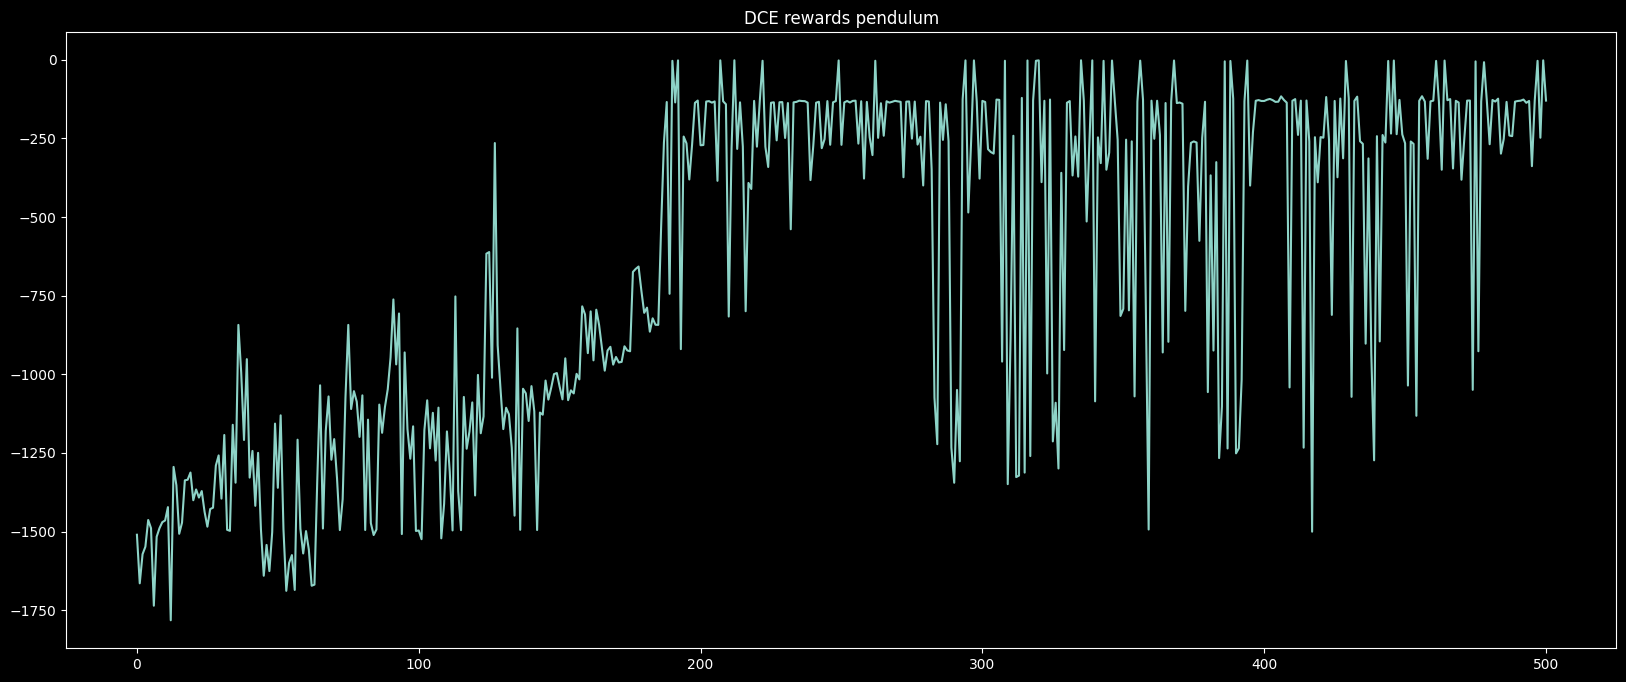

In [75]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 8))
    plt.plot(history_dce)
    plt.title('DCE rewards pendulum')
    print(f"Best reward = {max(history_dce)} on epoch {history_dce.index(max(history_dce))}")

In [ ]:
class Agent(nn.Module):
    def __init__(self, env, h_size=128):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers (we used 2 layers)
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.detach().numpy() * 2
    
    def act(self, state):
        state = torch.from_numpy(state).float()
        with torch.no_grad():
            action = self.forward(state)
        return action
        
    def evaluate(self, weights, gamma=1.0, max_t=200):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float()
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward
            if done:
                break
        return episode_return

In [ ]:
def cem(agent, n_iterations=1000, max_t=200, gamma=1.0, print_every=10, pop_size=100, elite_frac=0.2, sigma=2):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        Agent (object): agent instance
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    sigma_decrease = 1.5 / (n_iterations - 400)

    scores_deque = deque(maxlen=150)
    scores = []
    # Initialize the weight with random noise
    best_weight = sigma * np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        # Define the cadidates and get the reward of each candidate
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        # Select best candidates from collected rewards
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        if i_iteration > 200:
            sigma = 1.5
        elif i_iteration > 400:
            sigma -= sigma_decrease
            sigma = max(0.5, sigma)
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            

    return scores

In [ ]:
agent.fc1.weight.shape

torch.Size([128, 3])

In [ ]:
agent.fc1.bias.shape

torch.Size([128])

In [ ]:
agent.fc2.weight.shape

torch.Size([1, 128])

In [ ]:
agent.fc2.bias.shape

torch.Size([1])

In [ ]:
agent.get_weights_dim()

641

In [ ]:
%%time
agent = Agent(env_pendulum)
scores = cem(agent)

Episode 10	Average Score: -1443.94
Episode 20	Average Score: -1473.76
Episode 30	Average Score: -1473.44
Episode 40	Average Score: -1422.49
Episode 50	Average Score: -1314.49
Episode 60	Average Score: -1253.11
Episode 70	Average Score: -1227.64
Episode 80	Average Score: -1202.97
Episode 90	Average Score: -1190.99
Episode 100	Average Score: -1158.20
Episode 110	Average Score: -1103.37
Episode 120	Average Score: -1081.82
Episode 130	Average Score: -1047.92
Episode 140	Average Score: -1019.29
Episode 150	Average Score: -1000.52
Episode 160	Average Score: -958.96
Episode 170	Average Score: -905.80
Episode 180	Average Score: -846.40
Episode 190	Average Score: -826.80
Episode 200	Average Score: -828.99
Episode 210	Average Score: -829.58
Episode 220	Average Score: -822.37
Episode 230	Average Score: -802.35
Episode 240	Average Score: -779.49
Episode 250	Average Score: -785.21
Episode 260	Average Score: -772.29
Episode 270	Average Score: -783.14
Episode 280	Average Score: -771.05
Episode 290	Av

In [ ]:
env = gym.make('Pendulum-v1')
state_dim = 3
action_dim = 1

epochs = 200
trajectory_len = 200

noise_decrease = 1 / (epochs * trajectory_len)


agent_ddpg = DDPG(state_dim, action_dim, noise_decrease, action_scale=2)

history_ddpg = train(epochs, env, trajectory_len, agent)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


epoch [0] 	 reward [-1319.1635837369383]
epoch [1] 	 reward [-1596.1015480252956]
epoch [2] 	 reward [-1605.5431995361012]
epoch [3] 	 reward [-1508.912160826485]
epoch [4] 	 reward [-1362.3584763546053]
epoch [5] 	 reward [-1158.17518951576]
epoch [6] 	 reward [-947.0305589245899]
epoch [7] 	 reward [-1353.9827397509814]
epoch [8] 	 reward [-1528.1790639213186]
epoch [9] 	 reward [-1429.597128386525]
epoch [10] 	 reward [-1454.1102174740304]
epoch [11] 	 reward [-612.3357833692415]
epoch [12] 	 reward [-1549.3143084769238]
epoch [13] 	 reward [-1429.4123784491405]
epoch [14] 	 reward [-517.5521021237524]
epoch [15] 	 reward [-1149.3498644473498]
epoch [16] 	 reward [-778.848404643557]
epoch [17] 	 reward [-783.6295989483964]
epoch [18] 	 reward [-379.0593433322852]
epoch [19] 	 reward [-503.61966054080057]
epoch [20] 	 reward [-504.41399433394537]
epoch [21] 	 reward [-615.3324539597122]
epoch [22] 	 reward [-214.07385892620408]
epoch [23] 	 reward [-513.7115690846603]
epoch [24] 	 re